In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from scipy.interpolate import interp1d

In [57]:
df = pd.read_csv('data/transparency.csv')

In [58]:
def ice_transparency(df, datum=1950):
    df["z"] = df["depth"] - datum
    
    df[["scattering_len_norm", "absorption_len_norm"]] = RobustScaler().fit_transform(
        df[["scattering_len", "absorption_len"]]
    )

    # These are both roughly equivalent after scaling
    f_scattering = interp1d(df["z"], df["scattering_len_norm"])
    f_absorption = interp1d(df["z"], df["absorption_len_norm"])
    return f_scattering, f_absorption, df

In [59]:
f_scattering, f_absorption, df_processed = ice_transparency(df)

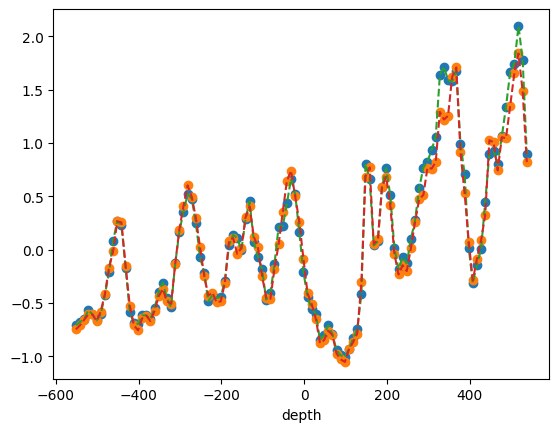

In [60]:
plt.plot(df['z'], df['scattering_len_norm'], 'o')
plt.plot(df['z'], df['absorption_len_norm'], 'o')
plt.plot(df['z'], f_scattering(df["z"]), '--')
plt.plot(df['z'], f_absorption(df["z"]), '--')
plt.xlabel('depth')

plt.show()

In [61]:
sensor_df = pd.read_csv('data/sensor_geometry.csv')

In [62]:
sensor_df['scattering'] = f_scattering(sensor_df['z'])
sensor_df['absorption'] = f_absorption(sensor_df['z'])

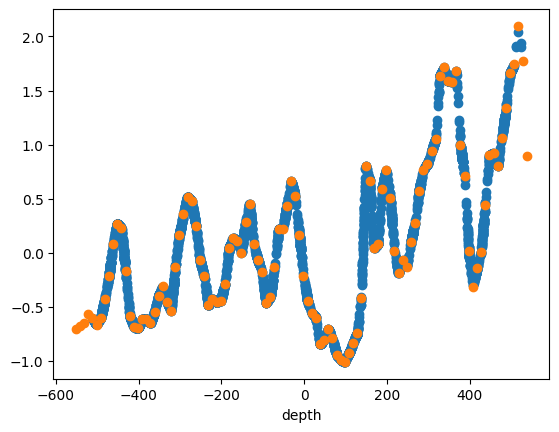

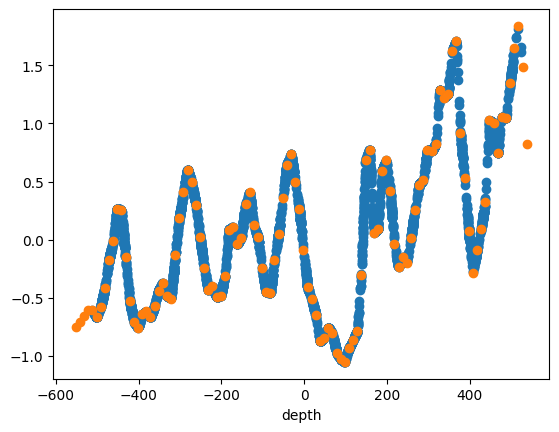

In [63]:
plt.plot(sensor_df['z'], sensor_df['scattering'], 'o')
plt.plot(df['z'], df['scattering_len_norm'], 'o')
plt.xlabel('depth')

plt.show()

plt.plot(sensor_df['z'], sensor_df['absorption'], 'o')
plt.plot(df['z'], df['absorption_len_norm'], 'o')
plt.xlabel('depth')

plt.show()

In [64]:
sensor_df["string"] = 0

for i in range(len(sensor_df) // 60):
    start, end = i * 60, (i * 60) + 60
    sensor_df.loc[start:end, "string"] = i

In [89]:
list_core = [25,26,36,45,44,34,80,81,85,83,84,78,79,82,35]
list_core = sorted(list_core)
list_core

[25, 26, 34, 35, 36, 44, 45, 78, 79, 80, 81, 82, 83, 84, 85]

In [112]:
sensor_df[(sensor_df["string"].isin(list_core[7:])) & (sensor_df["z"] > 0)]

,sensor_id,x,y,z,scattering,absorption,string,type
4680,4680,31.25,-72.93,188.29,0.583190,0.583442,78,regular
4681,4681,31.25,-72.93,178.28,0.080471,0.095781,78,regular
4682,4682,31.25,-72.93,168.27,0.048693,0.064279,78,regular
4683,4683,31.25,-72.93,158.26,0.669409,0.770391,78,regular
4684,4684,31.25,-72.93,148.24,0.774123,0.660440,78,regular
...,...,...,...,...,...,...,...,...
5105,5105,-10.97,6.72,140.36,-0.188585,-0.122046,85,regular
5106,5106,-10.97,6.72,130.35,-0.682741,-0.697252,85,regular
5107,5107,-10.97,6.72,120.34,-0.815397,-0.851668,85,regular
5108,5108,-10.97,6.72,110.33,-0.909814,-0.921377,85,regular


In [104]:
sensor_df['type'] = 'regular'

sensor_df.loc[(sensor_df['string'].isin(list_core)) & (sensor_df['z'] < -156.41 + 7), 'type'] = 'deep_core'

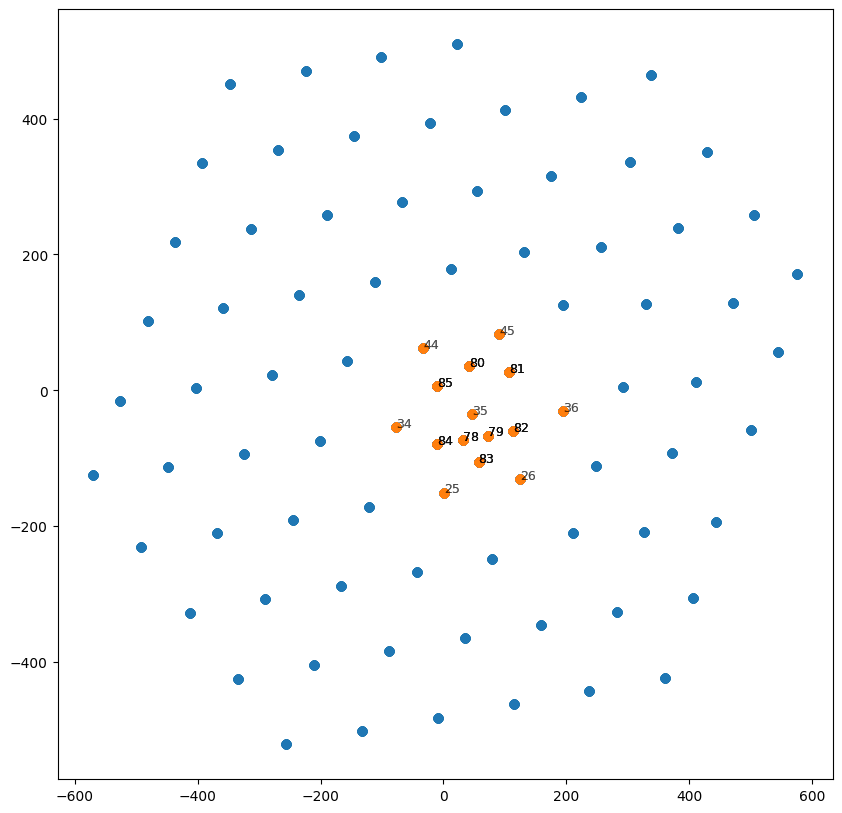

In [105]:
# size of the plot
plt.figure(figsize=(10, 10))
plt.scatter(sensor_df['x'], sensor_df['y'])
plt.scatter(sensor_df.loc[sensor_df['type'] == 'core', 'x'], sensor_df.loc[sensor_df['type'] == 'core', 'y'])
# print string number on top of each core
for i in range(len(sensor_df)):
    if sensor_df.loc[i, 'type'] == 'core':
        plt.text(sensor_df.loc[i, 'x'], sensor_df.loc[i, 'y'], sensor_df.loc[i, 'string'], fontsize=9, alpha=0.05)
plt.show()


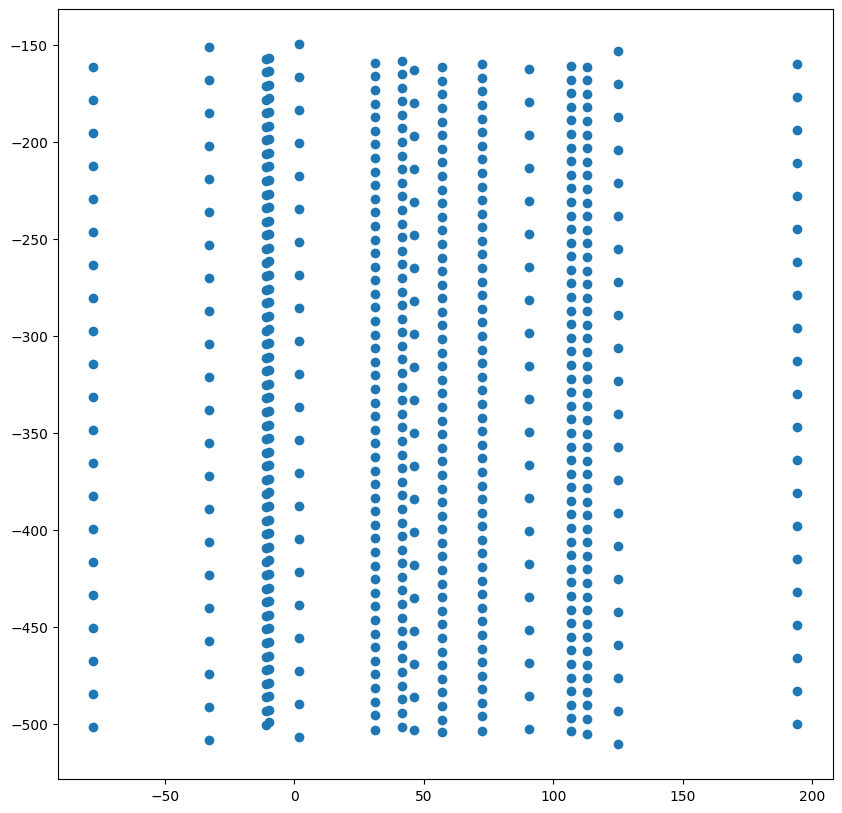

In [108]:
# plot x, z for core strings
plt.figure(figsize=(10, 10))
plt.scatter(sensor_df.loc[sensor_df['type'] == 'core', 'x'], sensor_df.loc[sensor_df['type'] == 'core', 'z'])
